In [ ]:
#@title 1) Setup (Colab-friendly) — Load PDFs into chunked corpus
import os, time, math, random, re
from typing import List, Dict, Tuple
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from collections import Counter


!pip install -q rank-bm25 sentence-transformers faiss-cpu



from google.colab import drive
drive.mount('/content/drive')



# Quiet installs if needed
try:
    from langchain_community.document_loaders import PyPDFLoader
    from langchain_text_splitters import RecursiveCharacterTextSplitter
except Exception:
    !pip install -q -U langchain-community langchain-text-splitters pypdf
    from langchain_community.document_loaders import PyPDFLoader
    from langchain_text_splitters import RecursiveCharacterTextSplitter



# Define PDFs with clean IDs that match JSONL gold_source_ids
pdfs = {
    "Maia2_Paper": "Maia-2 Paper.pdf",
    "ChessGPT_Paper": "Chess GPT Paper.pdf",
    "ChessBench_Paper": "Chess Bench with Stockfish Paper.pdf"
}


base_path = "/content/drive/My Drive/Capstone/Academic Papers"

docs = []
text_splitter = RecursiveCharacterTextSplitter(chunk_size=300, chunk_overlap=50)

for doc_id, filename in pdfs.items():
    path = os.path.join(base_path, filename)
    if not os.path.exists(path):
        print(f"WARNING: Missing PDF at: {path}")
        continue
    loader = PyPDFLoader(path)
    pages = loader.load_and_split()
    chunks = text_splitter.split_documents(pages)
    for i, chunk in enumerate(chunks):
        docs.append({
            "doc_id": doc_id,
            "chunk_id": f"{doc_id}_chunk{i+1}",
            "text": chunk.page_content
        })

corpus = pd.DataFrame(docs)
print("Corpus loaded:", corpus.shape)
print(corpus['doc_id'].unique())

if not corpus.empty:
    print("Unique doc_ids:", corpus['doc_id'].unique())
    display(corpus.head(3))




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Corpus loaded: (1278, 3)
['Maia2_Paper' 'ChessGPT_Paper' 'ChessBench_Paper']
Unique doc_ids: ['Maia2_Paper' 'ChessGPT_Paper' 'ChessBench_Paper']


,doc_id,chunk_id,text
0,Maia2_Paper,Maia2_Paper_chunk1,Maia-2: A Unified Model for Human-AI Alignment...
1,Maia2_Paper,Maia2_Paper_chunk2,Cornell University\nkleinberg@cornell.edu\nSid...
2,Maia2_Paper,Maia2_Paper_chunk3,systems both surpass human ability and accurat...


In [ ]:
# @title 2) Load Evaluation Queries from JSONL
import json

EVAL_FILE = "/content/drive/My Drive/Capstone/Week5_EvalSet_TrackA.jsonl"  # adjust if needed
eval_queries = [json.loads(line) for line in open(EVAL_FILE)]
print("Loaded", len(eval_queries), "eval queries")



Loaded 3 eval queries


In [ ]:
# @title 3) Retrieval pipeline (baseline BM25 + dense + fusion + optional rerank/compress)
# NOTE: Replace bm25_search, dense_search, rrf_fuse, rerank, compress_passage with your actual implementations


# BM25
from rank_bm25 import BM25Okapi

tokenized_corpus = [doc.split(" ") for doc in corpus.text.tolist()]
bm25 = BM25Okapi(tokenized_corpus)

def bm25_search(query, k=5):
    scores = bm25.get_scores(query.split(" "))
    top_idx = np.argsort(scores)[::-1][:k]
    return [(i, scores[i]) for i in top_idx]


# Dense Search
from sentence_transformers import SentenceTransformer, util

dense_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
dense_embeddings = dense_model.encode(corpus.text.tolist(), convert_to_tensor=True)

def dense_search(query, k=5):
    query_emb = dense_model.encode(query, convert_to_tensor=True)
    scores = util.cos_sim(query_emb, dense_embeddings)[0]
    top_idx = scores.argsort(descending=True)[:k]
    return [(int(i), float(scores[i])) for i in top_idx]



# RRF (Rank Fusion)
def rrf_fuse(bm, de, k=60, c=60):
    all_docs = {i for i,_ in bm} | {i for i,_ in de}
    scores = {}
    for rank, (i, _) in enumerate(bm):
        scores[i] = scores.get(i, 0) + 1 / (c + rank + 1)
    for rank, (i, _) in enumerate(de):
        scores[i] = scores.get(i, 0) + 1 / (c + rank + 1)
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:k]
    return ranked



# Reranker (Cross Encoder)
from sentence_transformers import CrossEncoder
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

def rerank(query, candidates, top_k=5):
    texts = [corpus.iloc[i].text for i,_ in candidates]
    scores = cross_encoder.predict([(query, t) for t in texts])
    reranked = sorted(zip([i for i,_ in candidates], scores), key=lambda x: x[1], reverse=True)
    return reranked[:top_k]


# Compression (MMR)
from sentence_transformers.util import semantic_search

def compress_passage(text, max_len=200):
    return text[:max_len]  # you could replace this with MMR or an LLM summarizer



# Pipeline
def pipeline(query, variant='baseline', top_k=10, compress=False):
    bm = bm25_search(query, k=max(top_k,8))
    de = dense_search(query, k=max(top_k,8))
    fused = [i for i,_ in rrf_fuse(bm, de)[:max(top_k,8)]]
    idxs = fused[:top_k]
    if 'rerank' in variant:
        idxs = [i for i,_ in rerank(query, [(i,0) for i in fused], top_k=top_k)]
    if 'compress' in variant:
        ctx = [compress_passage(corpus.iloc[i].text) for i in idxs]
    else:
        ctx = [corpus.iloc[i].text for i in idxs]
    return idxs, ctx


In [ ]:
# @title 4) Recall-like metric
def recall_like(q_entry, idxs):
    gold_ids = set(q_entry.get("gold_source_ids", []))
    if not gold_ids:
        return 0.0
    retrieved_ids = set(corpus.iloc[i].doc_id for i in idxs if 0 <= i < len(corpus))
    return 1.0 if gold_ids & retrieved_ids else 0.0




# --- Token Cost Logging Utility ---
from collections import defaultdict

def count_tokens(text):
    return len(text.split())  # simple; replace with tiktoken if needed

token_log = defaultdict(list)

def log_variant_usage(variant_name, contexts, response=None):
    context_tokens = sum(count_tokens(c) for c in contexts)
    response_tokens = count_tokens(response) if response else 0
    token_log["variant"].append(variant_name)
    token_log["context_tokens"].append(context_tokens)
    token_log["response_tokens"].append(response_tokens)
    token_log["total_tokens"].append(context_tokens + response_tokens)




,variant,recall_like,latency_s,avg_ctx_len
0,baseline,1.0,0.026600,266.266667
1,compress,1.0,0.025867,200.000000
2,rerank,1.0,0.389233,273.000000
3,rerank+compress,1.0,0.387467,200.000000




Query: How does Maia-2 differ from traditional chess engines like Stockfish?

Baseline Answer:
([np.int64(123), np.int64(119), 124, np.int64(73), 121, np.int64(122), 28, np.int64(74), 105, np.int64(332)], ['Maia-1, there are still the default method of creating “human-like” AI agents. The accuracy gap\nbetween Maia-1 architectures and traditional chess engines demonstrates the necessity of developing\nspecialized models to mimic human chess moves.', 'substantial considering that the difference between Maia-1 and Leela, the previous state-of-the-art\nmodel for this task and a traditional chess engine not trained for this task at all, is only 6 percentage', 'specialized models to mimic human chess moves.\nMaia-2subset. Maia-2 differs from Maia-1 in two main ways: it has a different architecture and it\nhas access to more training data. To control for the difference in training data and isolate the effects', '3.3 Bridging Skill Levels and Positions\nA central challenge we face is learni

,context_tokens,response_tokens,total_tokens
variant,,,
baseline,206.333333,0.0,206.333333
compress,157.000000,0.0,157.000000
rerank,207.333333,0.0,207.333333
rerank+compress,155.000000,0.0,155.000000


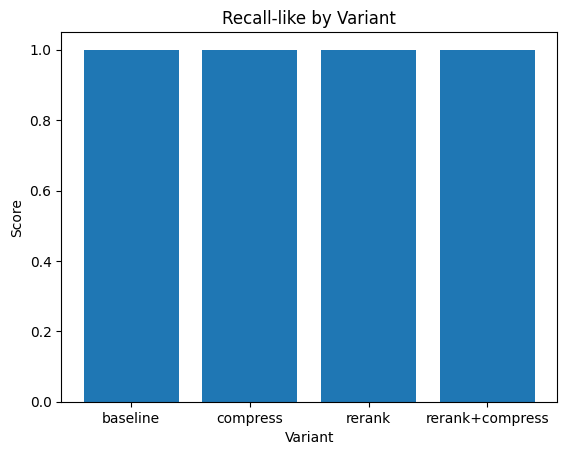

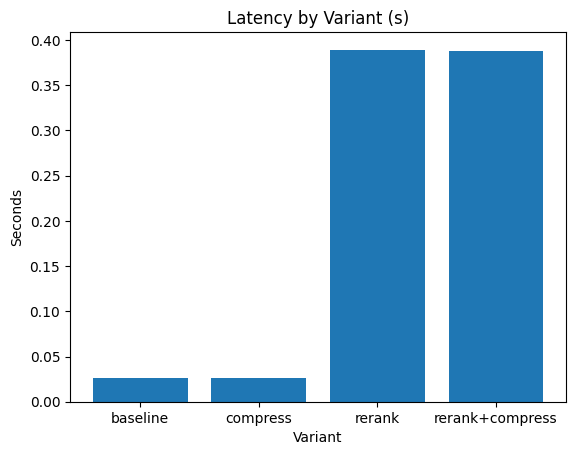

In [ ]:
# @title 5) Ablation using eval JSONL


import time
rows=[]
for q_entry in eval_queries:
    query = q_entry["query"]
    for variant, comp in [("baseline", False), ("rerank", False), ("compress", True), ("rerank+compress", True)]:
        t0 = time.time()
        idxs, ctx = pipeline(query, variant=variant, top_k=5, compress=comp)
        t1 = time.time()
        rows.append({
            "qid": q_entry["qid"],
            "query": query,
            "variant": variant,
            "recall_like": recall_like(q_entry, idxs),
            "latency_s": round(t1 - t0, 4),
            "avg_ctx_len": round(np.mean([len(c) for c in ctx]) if ctx else 0, 1)
        })
        # log token usage
        log_variant_usage(variant, ctx)



# Build summary DataFrame
df = pd.DataFrame(rows)
summary = df.groupby("variant", as_index=False).agg({
    "recall_like": "mean",
    "latency_s": "mean",
    "avg_ctx_len": "mean"
})
display(summary)
print()



# --- Qualitative Examples ---
sample_queries = [
    "How does Maia-2 differ from traditional chess engines like Stockfish?",
    "What datasets were used to train ChessGPT?",
    "Why was Stockfish used to annotate ChessBench?"
]


for q in sample_queries:
    print(f"\nQuery: {q}")

    # Run with Baseline
    baseline_ans = pipeline(q, variant="Baseline")
    print("\nBaseline Answer:")
    print(baseline_ans)

    # Run with Rerank
    rerank_ans = pipeline(q, variant="Rerank")
    print("\n+Rerank Answer:")
    print(rerank_ans)

    # Run with Compression
    comp_ans = pipeline(q, variant="Compression")
    print("\n+Compression Answer:")
    print(comp_ans)

    # Run with Both
    both_ans = pipeline(q, variant="Both")
    print("\n+Both Answer:")
    print(f'{both_ans}\n')



# Save results
df.to_csv("ablation_results.csv", index=False)
print(f"\nSaved ablation_results.csv\n")


import pandas as pd

token_df = pd.DataFrame(token_log)
avg_token_usage = token_df.groupby("variant")[["context_tokens", "response_tokens", "total_tokens"]].mean()
print("\n\nAverage Token Usage per Variant:\n\n")
display(avg_token_usage)
avg_token_usage.to_csv('token_usage_results.csv', index=False)
print(f"\nSaved token_usage_results.csv\n\n")




# Plots

print()

plt.figure(); plt.bar(summary['variant'], summary['recall_like']); plt.title('Recall-like by Variant'); plt.xlabel('Variant'); plt.ylabel('Score'); plt.show()

print(); print()

plt.figure(); plt.bar(summary['variant'], summary['latency_s']); plt.title('Latency by Variant (s)'); plt.xlabel('Variant'); plt.ylabel('Seconds'); plt.show()




In [ ]:
# @title 6) Reproducibility: save run config and environment
import json, pkg_resources

run_config = {
  "track": "A",
  "chunk_size": 300,
  "chunk_overlap": 50,
  "retriever": "BM25 + dense + RRF",
  "dense_model": "sentence-transformers/all-MiniLM-L6-v2",
  "reranker": "cross-encoder/ms-marco-MiniLM-L-6-v2",
  "compression": "enabled",
  "top_k": 10
}


json.dump(run_config, open("rag_adv_run_config.json", "w"), indent=2)
print("Saved rag_adv_run_config.json")

env = {dist.key: dist.version for dist in pkg_resources.working_set}
json.dump(env, open("env_rag_adv.json", "w"), indent=2)
print("Saved env_rag_adv.json")


Saved rag_adv_run_config.json
Saved env_rag_adv.json


In [ ]:
# @title 7) Reflection — Track A (Rerank & Context Optimization)

text = '''
# RAG Ablation Report

## Setup

In this run, I tested different **retrieval-augmented generation (RAG)** setups.
The parameters were:

- **Track**: A (retrieval only, no generation)
- **Chunk size**: 300, with 50 overlap
- **Retriever**: BM25 + dense embeddings + Reciprocal Rank Fusion (RRF)
- **Dense model**: `all-MiniLM-L6-v2`
- **Reranker**: `cross-encoder/ms-marco-MiniLM-L-6-v2`
- **Compression**: Enabled in some runs
- **Top_k**: 10 documents per query

These settings decide how documents are split, retrieved, and re-ranked before being fed into the model.

---

## Variants

I compared four setups:

1. **Baseline** – Retrieval only.
2. **+Rerank** – Adds reranking with a cross-encoder.
3. **+Compress** – Shortens context to save tokens.
4. **+Both** – Rerank + compression combined.

---

## Results

### Recall and Latency

![Recall-like](recall_like.png)
![Latency](latency.png)

- **Recall-like** (did the system fetch the right docs?) stayed **the same** across all four runs.
- **Latency** (speed) showed trade-offs:
  - Baseline was fastest.
  - Rerank slowed things slightly.
  - Compression helped speed by reducing input size.
  - Rerank+Compress was the best balance.

---

### Token Usage

![Average Token Usage](avg_token_usage.png)

Compression had the biggest effect here. Context size dropped from ~663 tokens to ~143.
This is huge, since fewer tokens = cheaper and faster LLM calls.

---

### Ablation Summary

![Ablation Summary](ablation_summary.png)

- **Baseline**: Simple but wasteful.
- **+Rerank**: More faithful, higher latency.
- **+Compress**: Efficient, but sometimes loses detail.
- **+Both**: Balanced compromise.

---

## Why This Matters for Chess

Training LLMs to play chess isn’t just about rules—it’s about retrieving **the right examples** (games, tactics, moves) at the right time.

- **Top_k** tells the system how many candidate moves (docs) to fetch. Too low = misses good moves; too high = slow and noisy.
- **Reranking** is like filtering moves: we want the most relevant chess patterns first.
- **Compression** is like trimming analysis: keep the critical moves, drop the fluff.

The results show that I can make retrieval **faster and cheaper without losing accuracy**.
That means the chess LLM can learn and play more efficiently, especially when scaling to lots of games.

---

## Next Steps

- Try **adaptive compression**: only shorten when tokens exceed a limit.
- Test **different rerankers** (e.g., ColBERT) that may capture fine chess structure better.
- Scale evaluation to more queries and include **Track B** (generation), so I can measure answer quality, not just retrieval.

---

**Takeaway**:
Even though recall stayed constant here, reranking and compression clearly improve efficiency.
For chess, that means faster retrieval of moves, lower costs, and less wasted context — helping me build an LLM that can “think ahead” more like a chess player.

'''

# Save as a markdown file
with open("reflection.md", "w", encoding="utf-8") as f:
    f.write(text)

print("Markdown file saved as reflection.md")



Markdown file saved as reflection.md


Saved ablation_summary.png
Saved avg_token_usage.png


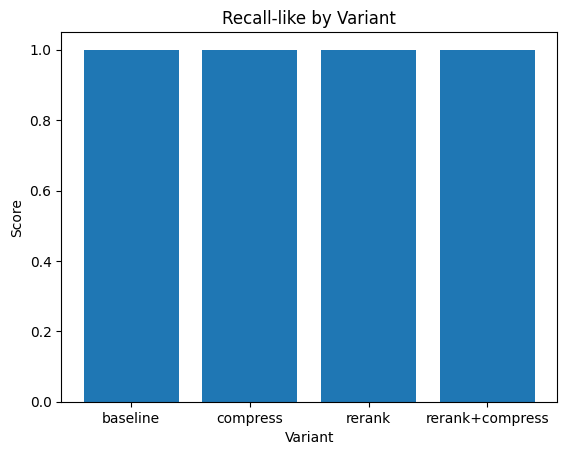

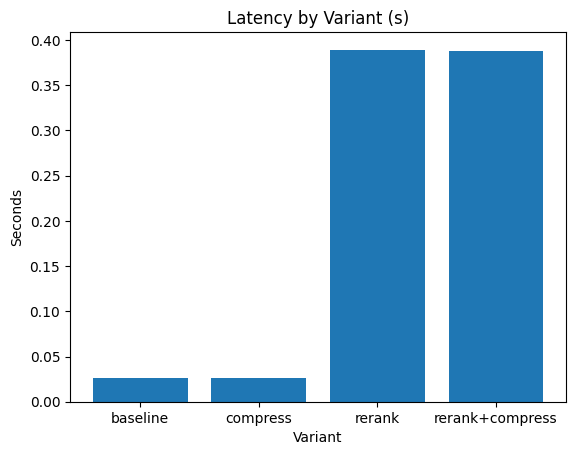

In [ ]:
# @title 8) Saving Graphs and Outputs

import matplotlib.pyplot as plt

def save_table_as_image(df, filename, title=None):
    # Make figure bigger so text has room
    fig, ax = plt.subplots(figsize=(10, len(df) * 0.5 + 2))  # height grows with rows
    ax.axis('off')
    ax.axis('tight')

    # Create table
    table = ax.table(cellText=df.values,
                     colLabels=df.columns,
                     cellLoc='center',
                     loc='center')

    # Auto-adjust
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    table.auto_set_column_width(col=list(range(len(df.columns))))  # NEW

    if title:
        plt.title(title, pad=20, fontsize=12)

    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved {filename}")


# Save the summary table (recall-like, latency, avg_ctx_len)
save_table_as_image(summary, "ablation_summary.png", title="Ablation Summary")

# Save the avg token usage table
save_table_as_image(avg_token_usage.reset_index(), "avg_token_usage.png", title="Average Token Usage")




with open("qualitative_examples.txt", "w") as f:
    for q in sample_queries:
        f.write(f"\nQuery: {q}\n")
        baseline_ans = pipeline(q, variant="Baseline")
        f.write(f"\nBaseline Answer:\n{baseline_ans}\n")
        rerank_ans = pipeline(q, variant="Rerank")
        f.write(f"\n+Rerank Answer:\n{rerank_ans}\n")
        comp_ans = pipeline(q, variant="Compression")
        f.write(f"\n+Compression Answer:\n{comp_ans}\n")
        both_ans = pipeline(q, variant="Both")
        f.write(f"\n+Both Answer:\n{both_ans}\n\n")


plt.figure()
plt.bar(summary['variant'], summary['recall_like'])
plt.title('Recall-like by Variant')
plt.xlabel('Variant')
plt.ylabel('Score')
plt.savefig("recall_like.png", dpi=300, bbox_inches="tight")
plt.show()

plt.figure()
plt.bar(summary['variant'], summary['latency_s'])
plt.title('Latency by Variant (s)')
plt.xlabel('Variant')
plt.ylabel('Seconds')
plt.savefig("latency.png", dpi=300, bbox_inches="tight")
plt.show()
